# 机器学习纳米学位
## 毕业项目：DeepTesla
2017 年4月25日

## 项目概况
本项目基于课程: [MIT 6.S094: Deep Learning for Self-Driving Cars](http://selfdrivingcars.mit.edu/deeptesla/)。 

## 问题描述
在车辆行驶过程中，我们通过摄像机对车辆周边的状况进行拍摄，同时同步记录方向盘转向。将视频中的每帧图片和每帧对应的Steering Angle作为训练数据传入模型， 对模型进行训练，从而实现模型从我们扑捉到的像素直接对应到Steering Angle的自我学习，也就是end-to-end学习。end-to-end指的是输入的是原始数据，输出的是最后结果，提取feature以及feature与最终结果的复杂映射关系交给模型自己处理。end to end的好处:通过缩减人工预处理和后续处理，尽可能使模型从原始输入到最终输出，给模型更多可以根据数据自动调节的空间，增加模型的整体契合度。

## 数据
本项目数据来自 [DeepTesla](https://github.com/nd009/capstone/tree/master/deep_tesla)。主要包括 tesla 在两种不同驾驶模式(human driving 和 autopilot)下的前置相机录制的视频和车辆的转向控制信号。 数据格式如下:
- 前置相机记录的视频:mkv 格式
- 行驶过程中的控制信号: CSV 格式

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(28)

In [2]:
# set the basic parameters
import params, utils

data_dir = params.data_dir
out_dir = params.out_dir
model_dir = params.model_dir
img_dir = os.path.abspath('./images/img/')

img_height = params.img_height
img_width = params.img_width
img_channels = params.img_channels
batch_size = params.batch_size

Using TensorFlow backend.


###   加载数据
从处理好的pickle file载入数据，对数据进行检查、分析。

In [3]:
# load RGB data
import pickle

pickle_file1 = 'data1.pickle'

with open ('data1.pickle', 'rb') as f:
    data = pickle.load(f)
    imgs_train_RGB = data['imgs_train_RGB']
    wheels_train_RGB = data['wheels_train_RGB']
    imgs_test_RGB = data['imgs_test_RGB']
    wheels_test_RGB = data['wheels_test_RGB']
    

In [4]:
# load YUV data
pickle_file2 = 'data2.pickle'

with open ('data2.pickle', 'rb') as f:
    data = pickle.load(f)
    imgs_train_YUV = data['imgs_train_YUV']
    wheels_train_YUV = data['wheels_train_YUV'] 
    imgs_test_YUV = data['imgs_test_YUV']
    wheels_test_YUV = data['wheels_test_YUV']
    

In [5]:
print(imgs_train_RGB.shape, wheels_train_RGB.shape)
print(imgs_train_YUV.shape, wheels_train_YUV.shape)
print(imgs_test_RGB.shape, wheels_test_RGB.shape)
print(imgs_test_YUV.shape, wheels_test_YUV.shape)

(48600, 66, 200, 3) (48600, 1)
(48600, 66, 200, 3) (48600, 1)
(2700, 66, 200, 3) (2700, 1)
(2700, 66, 200, 3) (2700, 1)


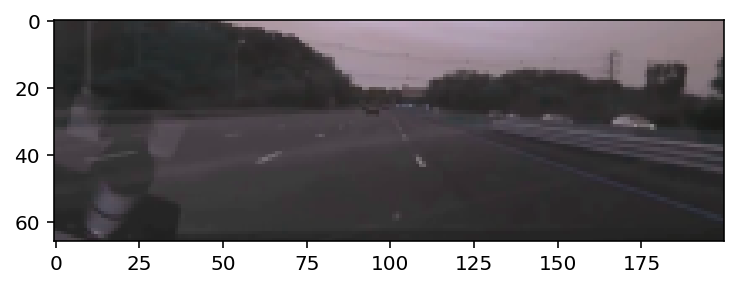

In [6]:
# visualize the processed picture RGB
plt.imshow(imgs_train_RGB[0])

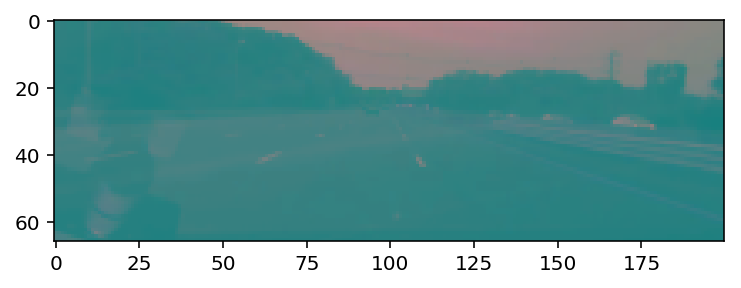

In [7]:
# visualize the processed picture YUV
plt.imshow(imgs_train_YUV[0])

### 数据分布
可视化Steering Angel的分布。

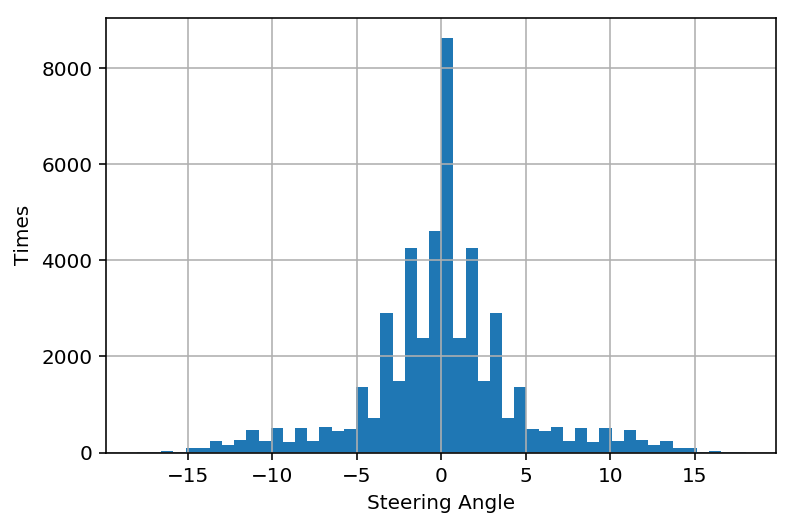

In [8]:
plt.figure
plt.hist(wheels_train_RGB,50);
plt.xlabel('Steering Angle')
plt.ylabel('Times')
#plt.title('Histogram of Steering Angle')
plt.grid(True)
plt.savefig(img_dir + '/angle_distribution.png')

上图表明Steering Angle大致成正态分布，小幅转角出现的次数多，大幅转角出现的次数少。

### 转角变化幅度
可视化转角随时间的变化。

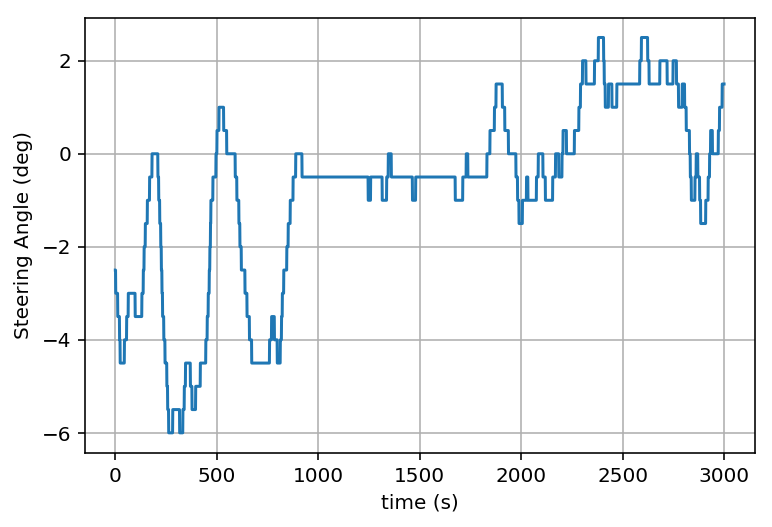

In [9]:
plt.figure
plt.plot(wheels_train_RGB[2000:5000])
plt.xlabel('time (s)')
plt.ylabel('Steering Angle (deg)')
#plt.title('Histogram of Steering Angle')
plt.grid(True)
plt.savefig(img_dir + '/Change_range.png')

### 数据打乱处理
利用train_test_split函数将样本数据进行打乱处理，增加数据的随机性。

In [10]:
# shuffle train data 
from sklearn.model_selection import train_test_split

# RGB mode
X_train_RGB, X_val_RGB, y_train_RGB, y_val_RGB = train_test_split(imgs_train_RGB, 
                                                                  wheels_train_RGB, train_size=0.8, random_state=28)
# YUV mode
X_train_YUV, X_val_YUV, y_train_YUV, y_val_YUV = train_test_split(imgs_train_YUV, 
                                                                  wheels_train_YUV, train_size=0.8, random_state=28)

### 构建模型

In [11]:
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Lambda
from keras.layers import Conv2D, Dropout
from keras import losses

###   基准模型
选用nvidia model作为基准模型。

In [12]:
# NVIDIA model
def nvidia_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
             input_shape=(img_height, img_width, img_channels)))
    
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Flatten())
    model.add(Dense(1164, kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dense(100,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dense(50,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dense(10,kernel_initializer='he_normal',
                    activation='elu'))
    
    model.add(Dense(1,kernel_initializer='he_normal'))
    
    model.compile(loss='mse', optimizer='Adadelta')
    
    return model

In [15]:
# Train the model with RGB data 
RGB_model = nvidia_model()
time_start = time.time()

# Fit the model
RGB_history = RGB_model.fit(X_train_RGB, y_train_RGB,
                              epochs=8, 
                              batch_size=batch_size,
                              validation_data=(X_val_RGB, y_val_RGB))

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= RGB_model.evaluate(imgs_test_RGB, wheels_test_RGB, batch_size=batch_size)
print()
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/8
38880/38880 [==============================] - 25s - loss: 9.2366 - val_loss: 2.8730
Epoch 2/8
38880/38880 [==============================] - 24s - loss: 1.9132 - val_loss: 1.3660
Epoch 3/8
38880/38880 [==============================] - 24s - loss: 0.8954 - val_loss: 0.6198
Epoch 4/8
38880/38880 [==============================] - 24s - loss: 0.9331 - val_loss: 0.6576
Epoch 5/8
38880/38880 [==============================] - 24s - loss: 0.3432 - val_loss: 0.4592
Epoch 6/8
38880/38880 [==============================] - 24s - loss: 0.3726 - val_loss: 0.3263
Epoch 7/8
38880/38880 [==============================] - 24s - loss: 0.2935 - val_loss: 0.3000
Epoch 8/8
38880/38880 [==============================] - 24s - loss: 0.2571 - val_loss: 0.2521
Training time: 198.7194962501526
2700/2700 [==============================] - 0s     

Test loss is:3.190716045079408


In [21]:
# Train the model with YUV data 
YUV_model = nvidia_model()
time_start = time.time()

# Fit the model
YUV_history = YUV_model.fit(X_train_YUV, y_train_YUV,
                              epochs=8, 
                              batch_size=batch_size,
                              validation_data=(X_val_YUV, y_val_YUV))

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= YUV_model.evaluate(imgs_test_YUV, wheels_test_YUV, batch_size=batch_size)
print()
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/8
38880/38880 [==============================] - 25s - loss: 7.9695 - val_loss: 2.2111
Epoch 2/8
38880/38880 [==============================] - 24s - loss: 1.4735 - val_loss: 0.9038
Epoch 3/8
38880/38880 [==============================] - 24s - loss: 0.7552 - val_loss: 0.6340
Epoch 4/8
38880/38880 [==============================] - 24s - loss: 0.5156 - val_loss: 0.3560
Epoch 5/8
38880/38880 [==============================] - 24s - loss: 0.3815 - val_loss: 0.3598
Epoch 6/8
38880/38880 [==============================] - 24s - loss: 0.3339 - val_loss: 0.3114
Epoch 7/8
38880/38880 [==============================] - 24s - loss: 0.2733 - val_loss: 0.2113
Epoch 8/8
38880/38880 [==============================] - 24s - loss: 0.2285 - val_loss: 0.2295
Training time: 198.36613750457764
2560/2700 [===========================>..] - ETA: 0s
Test loss is:3.354075421757168


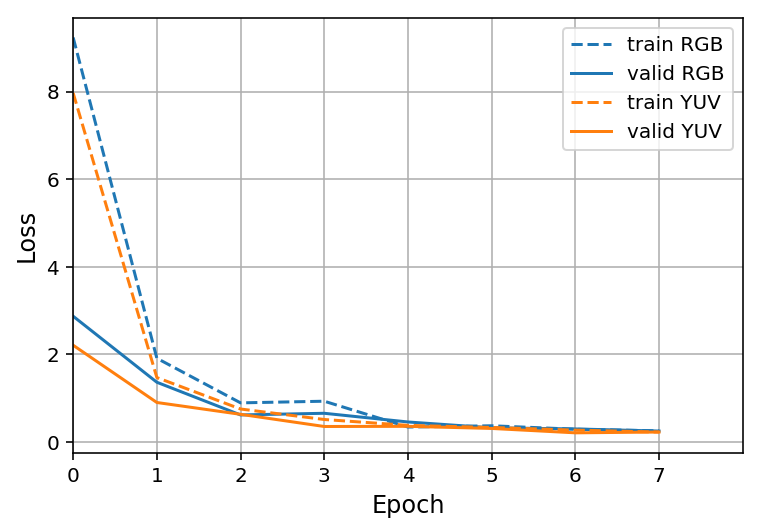

In [22]:
# summarize history for loss
plt.plot(RGB_history.history['loss'], 'C0--')
plt.plot(RGB_history.history['val_loss'], 'C0')

plt.plot(YUV_history.history['loss'], 'C1--')
plt.plot(YUV_history.history['val_loss'], 'C1')

# plt.title('model loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train RGB', 'valid RGB', 'train YUV', 'valid YUV'], loc='upper right')
plt.xlim((0,8))
plt.xticks(np.arange(0, 8, 1))
plt.grid()
plt.savefig(img_dir + "/nvidia_loss_compare.png", dpi=300)
plt.show()

### 改良模型

In [18]:
# refined model
def refined_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
             input_shape=(img_height, img_width, img_channels)))
    
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    model.add(Flatten())
    model.add(Dense(1164, kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.3))
    model.add(Dense(100,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.3))
    model.add(Dense(50,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.3))
    model.add(Dense(10,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1,kernel_initializer='he_normal'))
    
    model.compile(loss='mse', optimizer='Adadelta')
    
    return model

In [19]:
# Train the model with RGB_refined data 
RGB_refined_model = refined_model()
time_start = time.time()

# Fit the model
RGB_refined_history = RGB_refined_model.fit(X_train_RGB, y_train_RGB,
                              epochs=10, 
                              batch_size=batch_size,
                              validation_data=(X_val_RGB, y_val_RGB))

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= RGB_refined_model.evaluate(imgs_test_RGB, wheels_test_RGB, batch_size=batch_size)
print()
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 25s - loss: 13.7713 - val_loss: 5.5638
Epoch 2/10
38880/38880 [==============================] - 24s - loss: 7.0594 - val_loss: 2.7010
Epoch 3/10
38880/38880 [==============================] - 24s - loss: 5.3867 - val_loss: 2.2886
Epoch 4/10
38880/38880 [==============================] - 24s - loss: 4.6934 - val_loss: 1.3982
Epoch 5/10
38880/38880 [==============================] - 24s - loss: 4.3101 - val_loss: 1.4997
Epoch 6/10
38880/38880 [==============================] - 24s - loss: 4.1283 - val_loss: 1.8659
Epoch 7/10
38880/38880 [==============================] - 24s - loss: 4.0326 - val_loss: 1.3288
Epoch 8/10
38880/38880 [==============================] - 24s - loss: 3.8795 - val_loss: 1.8163
Epoch 9/10
38880/38880 [==============================] - 24s - loss: 3.7387 - val_loss: 1.1750
Epoch 10/10
38880/38880 [==============================] - 24s - loss: 3.6060 - val_lo

In [20]:
# Train the model with YUV_refined data 
YUV_refined_model = refined_model()
time_start = time.time()

# Fit the model
YUV_refined_history = YUV_refined_model.fit(X_train_YUV, y_train_YUV,
                              epochs=10, 
                              batch_size=batch_size,
                              validation_data=(X_val_YUV, y_val_YUV))

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= YUV_refined_model.evaluate(imgs_test_YUV, wheels_test_YUV, batch_size=batch_size)
print()
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 25s - loss: 12.5851 - val_loss: 4.4951
Epoch 2/10
38880/38880 [==============================] - 24s - loss: 6.8502 - val_loss: 3.0075
Epoch 3/10
38880/38880 [==============================] - 24s - loss: 5.4308 - val_loss: 2.1568
Epoch 4/10
38880/38880 [==============================] - 24s - loss: 4.8446 - val_loss: 1.8711
Epoch 5/10
38880/38880 [==============================] - 24s - loss: 4.5003 - val_loss: 1.5500
Epoch 6/10
38880/38880 [==============================] - 24s - loss: 4.1459 - val_loss: 1.5739
Epoch 7/10
38880/38880 [==============================] - 24s - loss: 3.9050 - val_loss: 1.1663
Epoch 8/10
38880/38880 [==============================] - 24s - loss: 3.8276 - val_loss: 1.1862
Epoch 9/10
38880/38880 [==============================] - 24s - loss: 3.6296 - val_loss: 1.5110
Epoch 10/10
38880/38880 [==============================] - 24s - loss: 3.5172 - val_lo

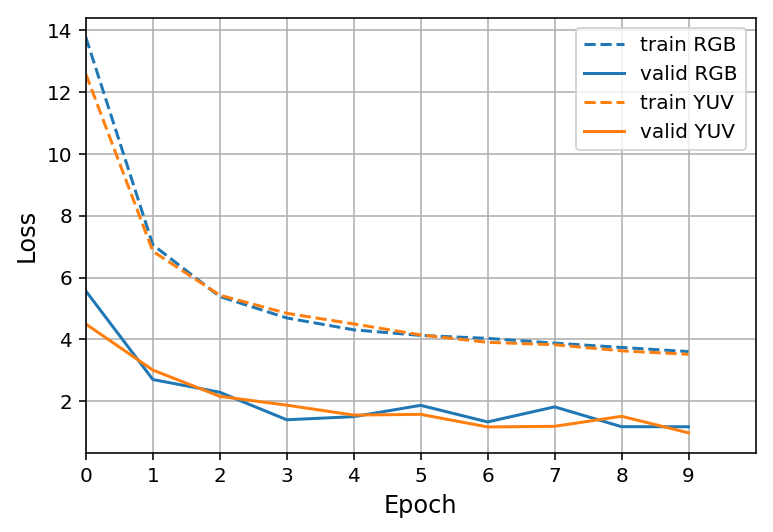

In [23]:
# summarize history for loss
plt.plot(RGB_refined_history.history['loss'], 'C0--')
plt.plot(RGB_refined_history.history['val_loss'], 'C0')

plt.plot(YUV_refined_history.history['loss'], 'C1--')
plt.plot(YUV_refined_history.history['val_loss'], 'C1')

# plt.title('model loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train RGB', 'valid RGB', 'train YUV', 'valid YUV'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 10, 1))
plt.grid()
plt.savefig(img_dir + "/refined_loss_compare.png", dpi=300)
plt.show()

### 最终模型

In [37]:
from keras.layers import MaxPooling2D
from keras import regularizers
from keras.layers.normalization import BatchNormalization

# final model
def final_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
             input_shape=(img_height, img_width, img_channels)))
    
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    kernel_initializer='he_normal', activation='elu'))
    
    
    model.add(Flatten())
    model.add(Dense(1164, kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(50,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(10,kernel_initializer='he_normal',
                    activation='elu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1,kernel_initializer='he_normal'))
    
    model.compile(loss='mse', optimizer='Adadelta')
    
    return model

In [38]:
# Train the model with RGB_final data 
RGB_final_model = final_model()
time_start = time.time()

# Fit the model
RGB_final_history = RGB_final_model.fit(X_train_RGB, y_train_RGB,
                              epochs=8, 
                              batch_size=batch_size,
                              validation_data=(X_val_RGB, y_val_RGB))

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= RGB_final_model.evaluate(imgs_test_RGB, wheels_test_RGB, batch_size=batch_size)
print()
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/8
38880/38880 [==============================] - 44s - loss: 10.0903 - val_loss: 6.1561
Epoch 2/8
38880/38880 [==============================] - 43s - loss: 4.8047 - val_loss: 1.7226
Epoch 3/8
38880/38880 [==============================] - 43s - loss: 3.7014 - val_loss: 1.0232
Epoch 4/8
38880/38880 [==============================] - 43s - loss: 3.2112 - val_loss: 0.8033
Epoch 5/8
38880/38880 [==============================] - 43s - loss: 2.9006 - val_loss: 0.8612
Epoch 6/8
38880/38880 [==============================] - 43s - loss: 2.7469 - val_loss: 0.5641
Epoch 7/8
38880/38880 [==============================] - 43s - loss: 2.5830 - val_loss: 0.7341
Epoch 8/8
38880/38880 [==============================] - 43s - loss: 2.5110 - val_loss: 0.5188
Training time: 350.78832960128784
2700/2700 [==============================] - 1s     

Test loss is:2.4501474706331887


In [41]:
# Train the model with YUV_final data 
YUV_final_model = final_model()
time_start = time.time()

# Fit the model
YUV_final_history = YUV_final_model.fit(X_train_YUV, y_train_YUV,
                              epochs=8, 
                              batch_size=batch_size,
                              validation_data=(X_val_YUV, y_val_YUV))

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= YUV_final_model.evaluate(imgs_test_YUV, wheels_test_YUV, batch_size=batch_size)
print()
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/8
38880/38880 [==============================] - 44s - loss: 9.5665 - val_loss: 8.1324
Epoch 2/8
38880/38880 [==============================] - 43s - loss: 4.8000 - val_loss: 2.7966
Epoch 3/8
38880/38880 [==============================] - 43s - loss: 3.8312 - val_loss: 2.1348
Epoch 4/8
38880/38880 [==============================] - 43s - loss: 3.3113 - val_loss: 1.0245
Epoch 5/8
38880/38880 [==============================] - 43s - loss: 3.0436 - val_loss: 1.3058
Epoch 6/8
38880/38880 [==============================] - 43s - loss: 2.8935 - val_loss: 0.8725
Epoch 7/8
38880/38880 [==============================] - 43s - loss: 2.6336 - val_loss: 0.6089
Epoch 8/8
38880/38880 [==============================] - 43s - loss: 2.5714 - val_loss: 0.6422
Training time: 350.7474503517151
2700/2700 [==============================] - 1s     

Test loss is:2.7268420689194293


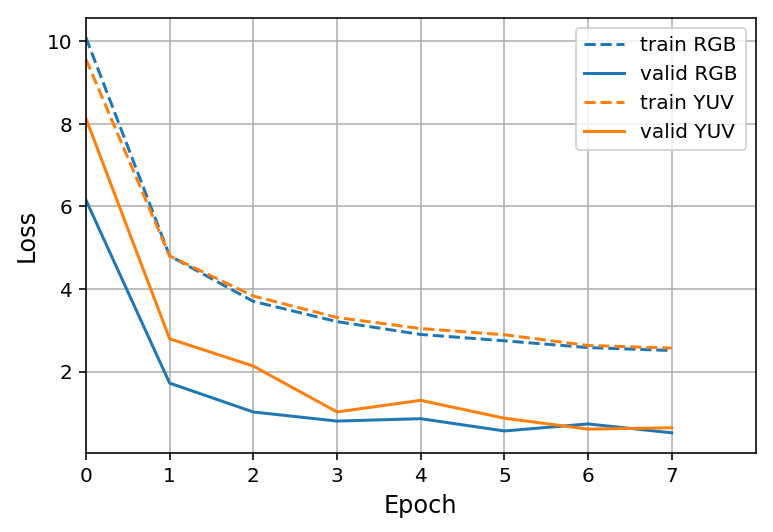

In [43]:
# summarize history for loss
plt.plot(RGB_final_history.history['loss'], 'C0--')
plt.plot(RGB_final_history.history['val_loss'], 'C0')

plt.plot(YUV_final_history.history['loss'], 'C1--')
plt.plot(YUV_final_history.history['val_loss'], 'C1')

# plt.title('model loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train RGB', 'valid RGB', 'train YUV', 'valid YUV'], loc='upper right')
plt.xlim((0,8))
plt.xticks(np.arange(0, 8, 1))
plt.grid()
plt.savefig(img_dir + "/final_loss_compare.png", dpi=300)
plt.show()

In [47]:
# model and json save path
model_saved_path = os.path.join(params.model_dir, "model.h5")
json_saved_path = os.path.join(params.model_dir, "model.json")

# save json
json_model = RGB_final_model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
# save model
RGB_final_model.save(model_saved_path)

### 模型结构

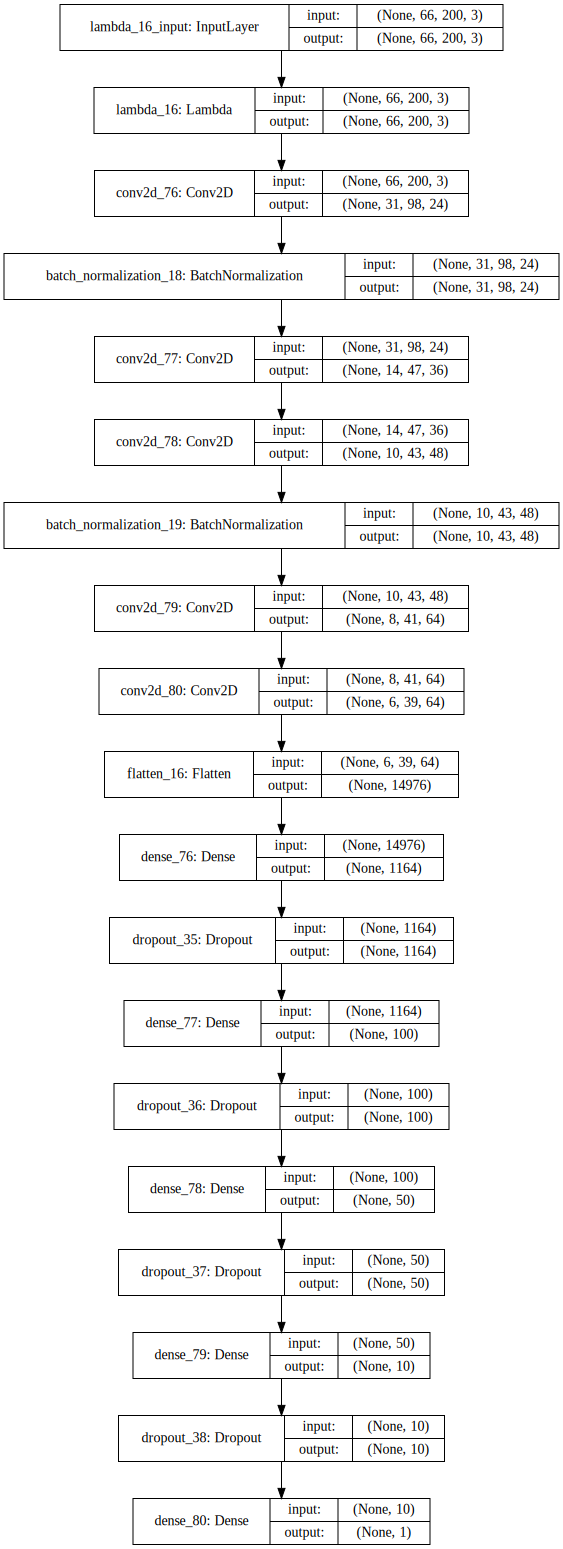

In [48]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(RGB_final_model, show_shapes=True).create(prog='dot', format='svg'))

### 模型评估

In [49]:
# steering angle predicted by the model
machine_steering = RGB_final_model.predict(imgs_test_YUV, batch_size=128, verbose=0)

In [50]:
# steering angle controlled by human
human_steering = utils.get_human_steering(10)

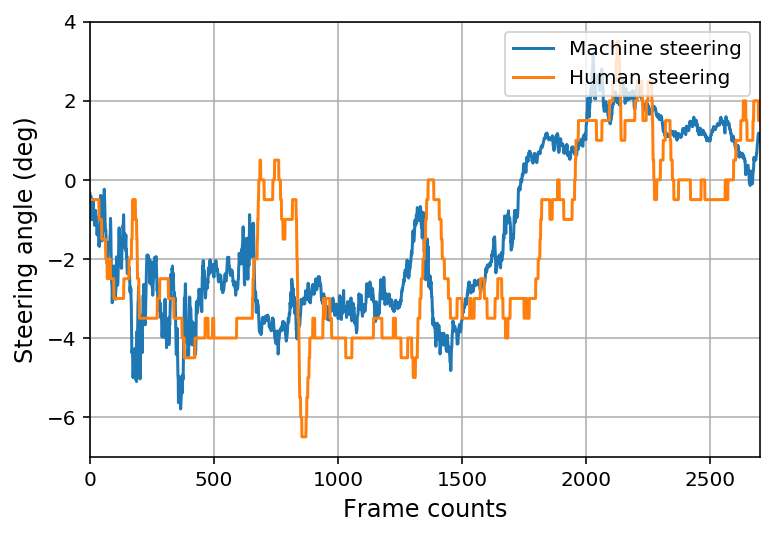

In [51]:
# plot the steering angle predicted by human and by model
plt.figure
plt.plot(machine_steering)
plt.plot(human_steering)
plt.ylabel('Steering angle (deg)', fontsize=12)
plt.xlabel('Frame counts', fontsize=12)
plt.legend(['Machine steering', 'Human steering'], loc='upper right')
plt.xlim((0,2700))


plt.grid()
plt.savefig(img_dir + "/result.png", dpi=300)
plt.show()